Trying to reproduce Figure 2.2 for https://webdocs.cs.ualberta.ca/~sutton/book/bookdraft2016sep.pdf. It shows how the value of ε affects the performance of ε-greedy algorithm

In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
matplotlib.style.use('ggplot')
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10, 6)

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

from rl import Environment, DPAgent
from gambler import GamblerEnv

In [2]:
# for reproducibility
np.random.seed(0)

In [3]:
K = 10 # number of arms

# Sample $q^*(a)$ for each arm

In [4]:
Q_STAR = np.random.randn(K)
Q_STAR

array([ 1.76405235,  0.40015721,  0.97873798,  2.2408932 ,  1.86755799,
       -0.97727788,  0.95008842, -0.15135721, -0.10321885,  0.4105985 ])

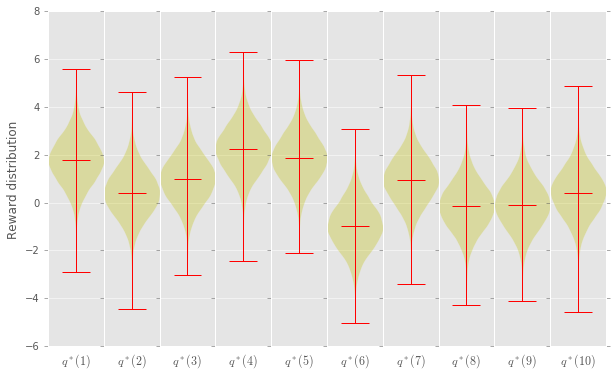

In [5]:
fig, axes = plt.subplots(1, 10, sharex=True, sharey=True, gridspec_kw={'wspace': 0, 'hspace': 0})
axes = axes.ravel()

for k, m in enumerate(Q_STAR):
    ax = axes[k]
    # plot the distribution very close to the real one by sampling a big number of data
    ax.violinplot(np.random.normal(m, scale=1, size=50000),  showmeans=True)
    ax.set_xticks([])
    ax.set_xlabel('$q^*({0})$'.format(k + 1))
    if k == 0:
        ax.set_ylabel('Reward distribution')

In [6]:
def gen_reward(action):
    return np.random.normal(Q_STAR[action], scale=1)

# Collection experience before time $t$

In [7]:
# init Q to be 0, q alone is a bad variable name, so use the_q
the_q = np.repeat(0., K)
the_q

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [8]:
# keep track of rewards collected and number of times taken for each action
sum_rewards = np.repeat(0., K)
counts = np.repeat(0., K)

In [9]:
# e.g. visit each action just once
for i in range(10):
    action = i % K
    val = gen_reward(action)
    sum_rewards[action] += val
    counts[action] += 1
    the_q[action] = sum_rewards[action] / counts[action]

In [10]:
the_q

array([ 0.7986595 ,  1.2846057 ,  0.52128434,  3.04577119,  2.02271541,
        0.50713147,  2.89880255, -0.57179059,  0.80315474, -0.03812594])

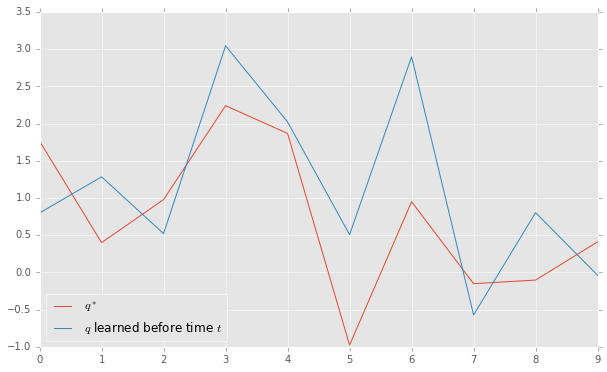

In [11]:
# comparison between the_Q and Q_STAR
plt.plot(Q_STAR, label='$q^*$')
plt.plot(the_q, label='$q$ learned before time $t$')
plt.legend(loc='best')

If the q has already learned the true argmax, the greedy policy will probably perform best

**Note**: Interestingly, my experience is that it very often finds the true argmax with small $t$, e.g. try each action just once

# Comparison policies

In [12]:
def pi_epsilon_greedy(the_q, epsilon=0):
    # return an action based on defined policy, when epsilon == 0, it's a greedy policy
    if np.random.random() > epsilon:
        return np.argmax(the_q)
    else:
        return np.random.randint(len(the_q))

In [13]:
def calc_average_rewards(steps, the_q, epsilon):
    total_rewards = 0
    average_rewards = [0]
    for s in steps[1:]: # when step is 0, reward is 0
        total_rewards += gen_reward(pi_epsilon_greedy(the_q, epsilon=epsilon))
        ave_r = total_rewards / (s + 1)
        average_rewards.append(ave_r)
    return np.array(average_rewards)

In [14]:
epsilons = [0, 0.01, 0.1]

In [15]:
n_rounds = 500
steps = np.arange(200)
ave_rewards_dd = {}
std_rewards_dd = {}
for eps in epsilons:
    res = None
    for i in range(n_rounds):
        _res = calc_average_rewards(steps, the_q, eps).reshape(1, -1)
        if res is None:
            res = _res
        else:
            res = np.vstack([res, _res])
    ave_rewards_dd[eps] = res.mean(axis=0)
    std_rewards_dd[eps] = res.std(axis=0)

In [16]:
ave_rewards_dd[0].shape

(200,)

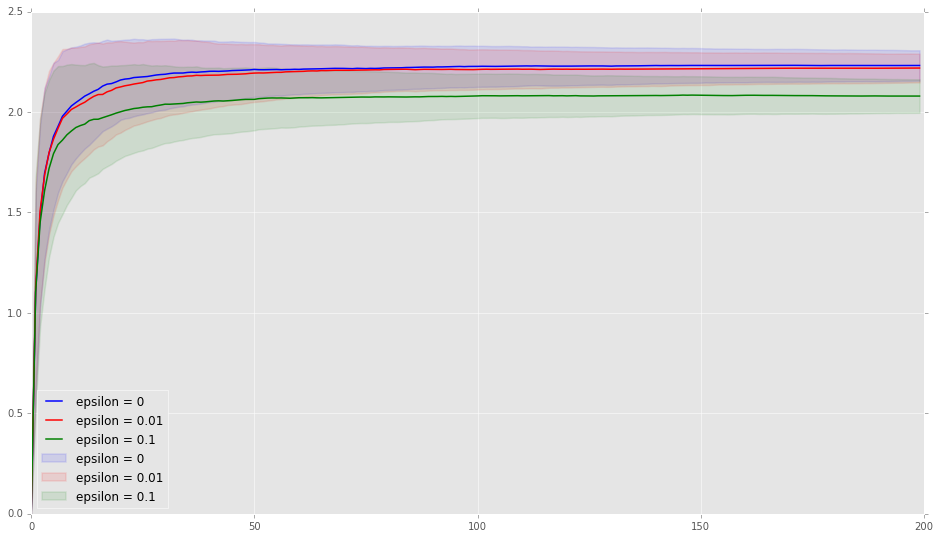

In [17]:
plt.figure(figsize=(16, 9))
colors = ['blue', 'red', 'green']
for k, eps in enumerate([0, 0.01, 0.1]):
    col = colors[k]
    plt.plot(steps, ave_rewards_dd[eps], color=col, lw=1.5, label='epsilon = {0}'.format(eps))
    plt.fill_between(steps, ave_rewards_dd[eps] - std_rewards_dd[eps],  ave_rewards_dd[eps] + std_rewards_dd[eps],
                     color=col, alpha=0.1, lw=1.5, label='epsilon = {0}'.format(eps))
plt.legend(loc='best')

That $\epsilon = 0$ performs best is because the `argmax(the_q)` reflex the true `argmax(Q_STAR)` already, $\epsilon = 0.1$ performs worse than $\epsilon = 0.01$ because of too much exploration, which results in lower reward.

**Question**: Not sure how to do experiment to produce a figure like the second plot on % optimal action in Figure 2.2. What does "different bandit problem" in the caption mean? Please message me if you know.